In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from matplotlib import gridspec

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear
from datasets import inputs, sf_inputs_discrete
from utils import get_firing_field, get_field_metrics
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Collect experiments in region of interest

In [2]:
# Eyeball a good region
desired_sigmas = ['sigma1.0']
desired_sparsity_range = [0.05, 0.1]
gamma = 0.8
model = 'identity'

In [7]:
results_dirs = []
data_dir = f'{configs.engram_dir}03_hannah_dset_revisions/'
for sparsity in os.listdir(data_dir):
    if not os.path.isdir(f'{data_dir}{sparsity}'): continue
    sigma_dirs = os.listdir(f'{data_dir}{sparsity}')
    for desired_sigma in desired_sigmas:
        if desired_sigma in sigma_dirs:
            results_dir = f'{data_dir}{sparsity}/{desired_sigma}/{gamma}/{model}/0/'
            results_path = results_dir + 'results.p'
            try:
                with open(results_path, 'rb') as f:
                    results = pickle.load(f)
            except:
                continue
            dset = results['dset']
            final_sparsity = dset.feature_maker.post_smooth_sparsity
            if final_sparsity >= desired_sparsity_range[0]:
                if final_sparsity <= desired_sparsity_range[1]:
                    results_dirs.append(results_dir)

# Plotting function

In [9]:
def plot_fields(results_dir):
    results_path = results_dir + 'results.p'
    fieldinfos_path = results_dir + 'field_infos.p'
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    if os.path.isfile(fieldinfos_path):
        with open(fieldinfos_path, 'rb') as f:
            fieldinfos = pickle.load(f)
    if 'hopfield' in results_path:
        outputs = results['outputs'].detach().numpy().squeeze()
    else:
        outputs = results['outputs']
    dset = results['dset']

    print('Sigma:')
    print(dset.feature_maker.spatial_sigma)
    print('Sparsity:')
    print(dset.feature_maker.post_smooth_sparsity)

    walk_xs = dset.xs
    walk_ys = dset.ys
    arena_length = int(np.sqrt(outputs.shape[1]))

    grid_x = 2; grid_y = 5;

    plt.figure(figsize = (3., 1.5))
    gs1 = gridspec.GridSpec(grid_x, grid_y)
    gs1.update(wspace=0.03, hspace=0.03) # set the spacing between axes. 

    neurs = np.arange(outputs.shape[1])
    np.random.shuffle(neurs)

    idx = 0
    for neur in neurs:
        ff, mask = get_firing_field(
            walk_xs, walk_ys, outputs[:,neur],
            arena_length, normalize=True
            )
        ax = plt.subplot(gs1[idx])
        plt.axis('on')
        if np.sum(fieldinfos[neur][1]) == 0: continue # Skip non-place cells
#         ff -= ff.min()
        
        ff -= np.percentile(ff, 5)
        ff[ff<0] = 0
        
        ff = ff/ff.max()
        ax.imshow(ff, vmin=0., vmax=1, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])

        idx += 1
        if idx == grid_x*grid_y: break
    plt.suptitle('Simulated Place Fields')
    plt.tight_layout()
    plt.savefig('../figures/S6_identity_d.png', dpi=300, transparent=True)
    plt.show()

# Plot all relevant experiments

In [10]:
for x in results_dirs:
    print(x)
    plot_fields(x)

# Choose one experiment to show

In [6]:
from scipy import ndimage
import matplotlib.gridspec as gridspec

Sigma:
1.0
Sparsity:
0.05978905008613128


/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_8879/22378436.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


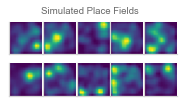

In [22]:
# Again, just eyeball a good one
plot_fields('/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.01663157894736842/sigma1.0/0.8/linear/0/')